/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


(<Figure size 900x1000 with 1 Axes>, <Axes: >)

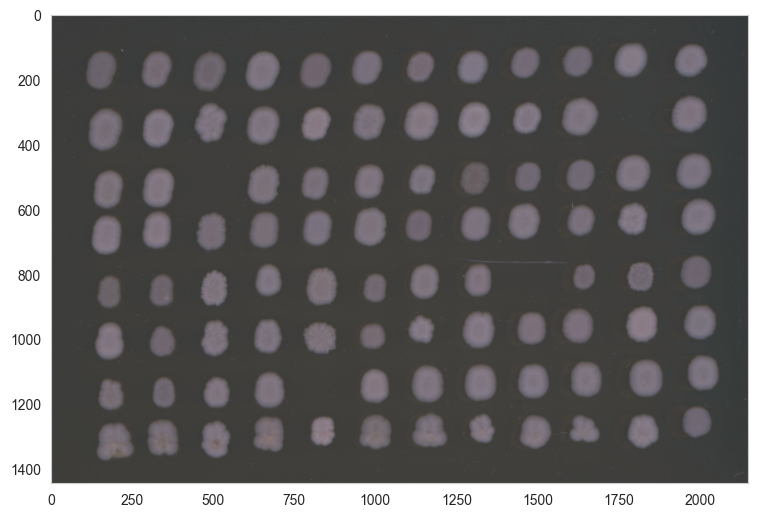

In [5]:
from phenotypic import GridImage, Image

from phenotypic.data import load_plate_72hr

plate_image = GridImage(load_plate_72hr(), name='Plate72Hr')
plate_image.show()

In [22]:
from skimage.color import rgb2gray
print(rgb2gray(load_plate_72hr()).dtype)

float64


/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


In [6]:
from pympler import asizeof

print(f'Array size: {asizeof.asizeof(load_plate_72hr()) / 1000000} mbytes')
print(f'Phenotypic.GridImage: {asizeof.asizeof(plate_image) / 1000000} mbytes')
print(f'Phenotypic.Image: {asizeof.asizeof(Image(load_plate_72hr())) / 1000000} mbytes')

print(f'Ratio: {asizeof.asizeof(plate_image) / asizeof.asizeof(load_plate_72hr())}')

Array size: 9.31396 mbytes
Phenotypic.GridImage: 21.748936 mbytes
Phenotypic.Image: 21.748056 mbytes
Ratio: 2.3350901227834346


/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


In [7]:
import os, psutil

proc = psutil.Process(os.getpid())

# RSS: resident set size
rss = proc.memory_info().rss

# Full info gives you USS (unique) on Linux via memory_full_info().uss
full = proc.memory_full_info()
uss = getattr(full, "uss", None)      # Unique Set Size (Linux)
pss = getattr(full, "pss", None)      # Proportional Set Size (Linux)

print(f"RSS = {rss/1024**2:.1f} MB")
if uss is not None:
    print(f"USS = {uss/1024**2:.1f} MB")
if pss is not None:
    print(f"PSS = {pss/1024**2:.1f} MB")

RSS = 542.8 MB
USS = 272.8 MB


In [8]:
total_data_footprint = 0
for data_key, data_value in plate_image._data.__dict__.items():
    print(
        f'{data_key} | {data_value.dtype}: {asizeof.asizeof(data_value) / 1000000} mbytes | shape: {data_value.shape} | fold-increase: {asizeof.asizeof(data_value) / asizeof.asizeof(load_plate_72hr())}')
    total_data_footprint += asizeof.asizeof(data_value)
print(f'Total data footprint: {total_data_footprint / 1000000} mbytes')
print(f'Class overhead: {asizeof.asizeof(plate_image) / 1000000 - total_data_footprint / 1000000}')

array | uint8: 9.31396 mbytes | shape: (1444, 2150, 3) | fold-increase: 1.0
matrix | uint16: 6.20936 mbytes | shape: (1444, 2150) | fold-increase: 0.6666723928382772
enh_matrix | uint16: 6.20936 mbytes | shape: (1444, 2150) | fold-increase: 0.6666723928382772
sparse_object_map | uint16: 0.009936 mbytes | shape: (1444, 2150) | fold-increase: 0.001066785771036165
Total data footprint: 21.742616 mbytes
Class overhead: 0.006319999999998771


/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


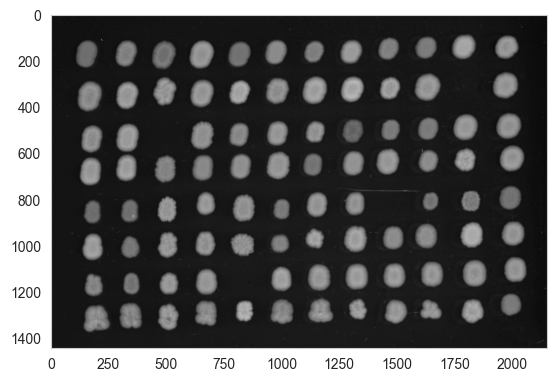

In [9]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
fig, ax = plt.subplots()
ax.grid(False)
ax.imshow(rgb2gray(plate_image.array[:]), cmap='gray')

(<Figure size 800x600 with 1 Axes>, <Axes: >)

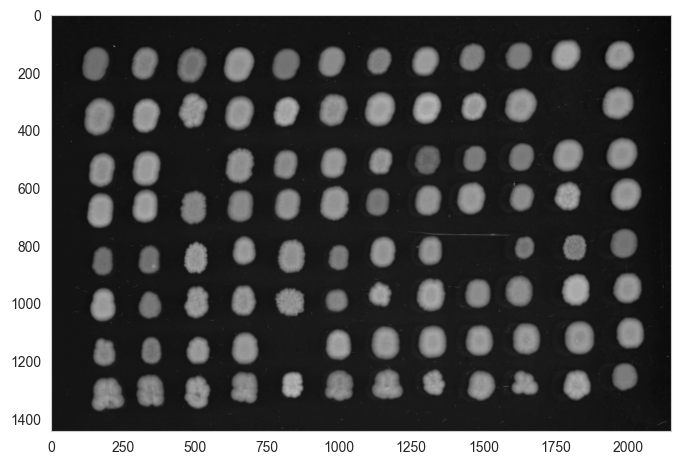

In [10]:
plate_image.matrix.show()

/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/alex/Library/CloudStorage/ProtonDrive-alxxander.nguyen@protonmail.com-folder/Research/Wheeldon/Projects/KluvMarx-PopGenomics/.venv/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


(<Figure size 900x1000 with 1 Axes>, <Axes: >)

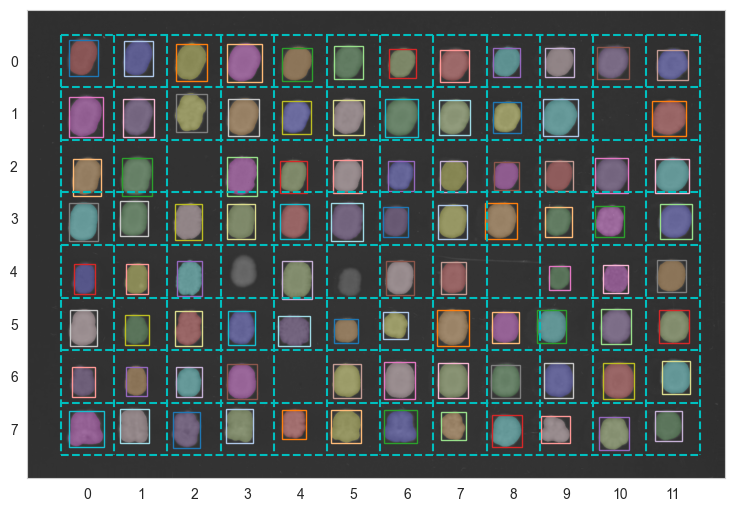

In [11]:
from phenotypic.pipeline import ImagePipeline
from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
from phenotypic.detection import WatershedDetector
from phenotypic.grid import GridAligner, GridApply, MinResidualErrorReducer, LinRegResidualOutlierRemover
from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover
from phenotypic.morphology import MaskFill

from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture

kmarx_pipeline = ImagePipeline(
    ops={
        'blur': GaussianSmoother(sigma=5),
        'clahe': CLAHE(),
        'median filter': MedianEnhancer(),
        'detection': WatershedDetector(footprint='auto', min_size=50, relabel=True),
        'mask_fill':MaskFill(),
        'RemoveBorderObjects': BorderObjectRemover(),
        'low circularity remover': LowCircularityRemover(0.7),
        'reduce by section residual error': MinResidualErrorReducer(),
        'outlier removal': LinRegResidualOutlierRemover(),
        'align': GridAligner(),
        'grid_reduction': MinResidualErrorReducer(),
    },
    measurements={
        'MeasureColor': MeasureColor(),
        'MeasureShape': MeasureShape(),
        'MeasureIntensity': MeasureIntensity(),
        'MeasureTexture': MeasureTexture(scale=3),
        'MeasureTexture2': MeasureTexture(scale=4),
    }
)

pipeline_output = kmarx_pipeline.apply(plate_image)
pipeline_output.objects.relabel()
pipeline_output.show_overlay()



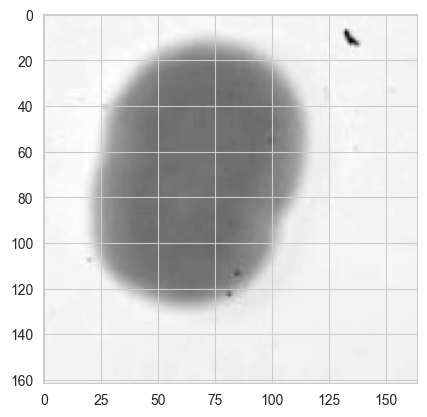

In [12]:
colony_image = pipeline_output.grid[0]
from skimage.util import invert
colony_matrix = invert(colony_image.matrix[:])

import matplotlib.pyplot as plt
plt.imshow(colony_matrix, cmap='gray')

(<Figure size 800x600 with 1 Axes>, <Axes: >)

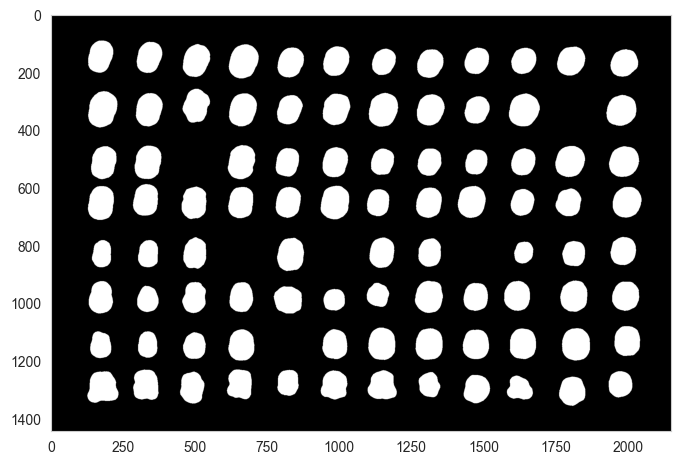

In [13]:
pipeline_output.objmask.show()

In [14]:
# from phenotypic.pipeline import ImagePipeline
# from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
# from phenotypic.detection import OtsuDetector
# from phenotypic.grid import GridAligner, GridApply, MinResidualErrorReducer, LinRegResidualOutlierRemover
# from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover
#
# from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture
#
# kmarx_pipeline = ImagePipeline(
#     ops={
#         'blur': GaussianSmoother(sigma=10),
#         'clahe': CLAHE(),
#         'median filter': MedianEnhancer(),
#         'detection': OtsuDetector(),
#         'border_removal': BorderObjectRemover(50),
#         'low circularity remover': LowCircularityRemover(0.6),
#         'small object remover': SmallObjectRemover(100),
#         'Reduce by section residual error': MinResidualErrorReducer(),
#         'outlier removal': LinRegResidualOutlierRemover(),
#         'align': GridAligner(),
#         'section-level detect': GridApply(ImagePipeline({
#             'blur': GaussianSmoother(sigma=5),
#             'median filter': MedianEnhancer(),
#             'contrast stretching': ContrastStretching(),
#             'detection': OtsuDetector(),
#         }
#         )
#         ),
#         'small object remover 2': SmallObjectRemover(100),
#         'grid_reduction': MinResidualErrorReducer()
#     },
#     measurements={
#         'MeasureColor': MeasureColor(),
#         'MeasureShape': MeasureShape(),
#         'MeasureIntensity': MeasureIntensity(),
#         'MeasureTexture': MeasureTexture()}
# )
#
# pipeline_output = kmarx_pipeline.apply(plate_image)
# pipeline_output.show_overlay()
#


In [15]:
shape_measurements = MeasureShape().measure(pipeline_output)
shape_measurements

,Shape_Area,Shape_Perimeter,Shape_Circularity,Shape_ConvexArea,Shape_MedianRadius,Shape_MeanRadius,Shape_Eccentricity,Shape_Solidity,Shape_Extent,Shape_BboxArea,Shape_MajorAxisLength,Shape_MinorAxisLength,Shape_Compactness,Shape_Orientation
ObjectLabel,,,,,,,,,,,,,,
1,7613.0,336.149278,0.846645,316.616421,14.000000,15.657694,0.697950,24.044868,0.781301,9744.0,116.534636,83.455915,1.181133,-0.295711
2,7444.0,330.149278,0.858214,311.401289,14.000000,15.639960,0.667234,23.904846,0.774449,9612.0,112.953356,84.133112,1.165211,-0.341136
3,8283.0,348.291414,0.858049,328.146697,14.764823,16.522793,0.650111,25.241759,0.764820,10830.0,117.940726,89.615995,1.165435,-0.377883
4,9452.0,369.362482,0.870619,348.695853,16.000000,17.858059,0.606530,27.106718,0.762873,12390.0,123.135551,97.900252,1.148608,-0.405979
5,7327.0,322.492424,0.885313,306.337331,14.000000,15.824517,0.593671,23.918077,0.789377,9282.0,107.748365,86.705934,1.129544,-0.433380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,7271.0,331.320851,0.832351,311.443954,13.601471,15.143947,0.670793,23.346095,0.770641,9435.0,112.064134,83.111779,1.201416,0.022903
87,4979.0,269.036580,0.864429,255.293855,11.401754,12.778769,0.567022,19.503015,0.763065,6525.0,88.059008,72.534446,1.156833,0.208065
88,7021.0,317.078210,0.877558,300.049030,13.892444,15.538481,0.449955,23.399509,0.770861,9108.0,100.314878,89.586319,1.139525,-0.341296


In [16]:
intensity_measurements = MeasureIntensity().measure(pipeline_output)
intensity_measurements

,Intensity_IntegratedIntensity,Intensity_MinimumIntensity,Intensity_MaximumIntensity,Intensity_MeanIntensity,Intensity_MedianIntensity,Intensity_StandardDeviationIntensity,Intensity_CoefficientVarianceIntensity,Intensity_LowerQuartileIntensity,Intensity_UpperQuartileIntensity,Intensity_InterquartileRangeIntensity
ObjectLabel,,,,,,,,,,
1,2933.907496,0.311381,0.444404,0.385381,0.394095,0.017653,0.045813,0.376287,0.397699,0.021412
2,3082.114770,0.310356,0.449218,0.414040,0.424598,0.028486,0.068809,0.399439,0.434577,0.035139
3,3273.688938,0.321174,0.431179,0.395230,0.398825,0.021217,0.053689,0.385761,0.411769,0.026008
4,4198.360555,0.312285,0.483596,0.444177,0.459034,0.035864,0.080750,0.428097,0.470268,0.042170
5,3103.462160,0.304337,0.457370,0.423565,0.442288,0.033746,0.079682,0.406198,0.448688,0.042490
...,...,...,...,...,...,...,...,...,...,...
86,3202.572979,0.303707,0.499251,0.440458,0.452624,0.036094,0.081957,0.418417,0.469010,0.050593
87,2214.045903,0.301712,0.506689,0.444677,0.458502,0.041363,0.093036,0.421067,0.476198,0.055131
88,3095.935757,0.325541,0.495491,0.440954,0.454324,0.036594,0.083000,0.415946,0.469936,0.053991


In [17]:
texture_measurements = MeasureTexture().measure(pipeline_output)
texture_measurements

,Texture_AngularSecondMoment-deg(0)-intensity-scale(5),Texture_AngularSecondMoment-deg(45)-intensity-scale(5),Texture_AngularSecondMoment-deg(90)-intensity-scale(5),Texture_AngularSecondMoment-deg(135)-intensity-scale(5),Texture_Contrast-deg(0)-intensity-scale(5),Texture_Contrast-deg(45)-intensity-scale(5),Texture_Contrast-deg(90)-intensity-scale(5),Texture_Contrast-deg(135)-intensity-scale(5),Texture_Correlation-deg(0)-intensity-scale(5),Texture_Correlation-deg(45)-intensity-scale(5),...,Texture_DifferenceEntropy-deg(90)-intensity-scale(5),Texture_DifferenceEntropy-deg(135)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(135)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(135)-intensity-scale(5)
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,0.053047,0.048810,0.056554,0.050361,8.519983,12.439303,7.072454,10.999136,0.707360,0.560027,...,2.274691,2.791257,-0.239210,-0.156312,-0.257908,-0.155220,0.890573,0.797531,0.906960,0.798749
2,0.011027,0.009458,0.011242,0.009929,22.748081,38.833958,17.145592,28.617118,0.712929,0.486471,...,3.099941,3.480006,-0.181226,-0.114087,-0.186449,-0.120370,0.882797,0.779693,0.889790,0.794551
3,0.013545,0.011691,0.015514,0.013189,12.273953,22.113533,10.766500,16.845313,0.735811,0.502651,...,2.866350,3.158140,-0.189864,-0.104399,-0.200976,-0.131798,0.884142,0.749557,0.895357,0.806123
4,0.016298,0.012628,0.017936,0.014594,26.777026,45.687348,25.262928,38.975884,0.787803,0.619285,...,3.141417,3.552291,-0.260781,-0.168730,-0.257212,-0.174056,0.945404,0.871984,0.944154,0.879072
5,0.027618,0.024700,0.028540,0.025707,24.824996,44.822868,24.984866,36.103190,0.778140,0.577135,...,3.007088,3.496387,-0.269388,-0.171518,-0.237613,-0.167362,0.940469,0.860014,0.923407,0.856963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.005052,0.004336,0.005155,0.004238,37.344201,56.034079,32.112896,59.145744,0.717889,0.570297,...,3.529644,4.041048,-0.180369,-0.104427,-0.176424,-0.108925,0.904108,0.790082,0.901496,0.799215
87,0.003909,0.003393,0.003885,0.003271,49.800616,76.172437,47.029322,80.131735,0.708082,0.549896,...,3.805679,4.226019,-0.180122,-0.120171,-0.174954,-0.110919,0.909437,0.828949,0.905318,0.810544
88,0.005622,0.004715,0.005976,0.004880,23.384380,39.438688,22.657778,36.786960,0.834027,0.707601,...,3.304823,3.690349,-0.250543,-0.167184,-0.227739,-0.159809,0.953043,0.890959,0.941484,0.883118


In [18]:
color_measurements =MeasureColor().measure(pipeline_output)
color_measurements

,Hue_Mean,Hue_StdDev,Hue_Median,Hue_CoefficientVariance,Saturation_Mean,Saturation_StdDev,Saturation_Median,Saturation_CoefficientVariance,Brightness_Mean,Brightness_StdDev,Brightness_Median,Brightness_CoefficientVariance
ObjectLabel,,,,,,,,,,,,
1,290.008881,22.283214,292.500000,0.076846,0.079669,0.014223,0.075114,0.178551,0.410361,0.021639,0.417623,0.052737
2,300.580810,23.864119,306.000000,0.079404,0.082646,0.010445,0.084483,0.126403,0.441241,0.031513,0.454740,0.071430
3,300.223538,22.705550,299.847863,0.075638,0.074059,0.012040,0.071939,0.162592,0.418328,0.024068,0.424867,0.057541
4,285.479163,30.303409,294.545455,0.106161,0.085615,0.012134,0.086614,0.141741,0.475613,0.040013,0.492226,0.084139
5,283.704428,34.302428,283.636364,0.120926,0.087492,0.015008,0.090164,0.171565,0.454867,0.039871,0.474341,0.087667
...,...,...,...,...,...,...,...,...,...,...,...,...
86,278.804489,74.315770,294.545455,0.266588,0.088155,0.016866,0.087147,0.191350,0.472441,0.040148,0.486995,0.084991
87,290.870782,48.225720,294.545455,0.165831,0.087616,0.014570,0.087591,0.166331,0.476794,0.046891,0.493091,0.098367
88,298.727902,32.386532,297.566016,0.108430,0.081945,0.011455,0.085023,0.139813,0.469962,0.040480,0.485493,0.086146


In [19]:
pipeline_measurements = kmarx_pipeline.measure(pipeline_output)

In [20]:
pipeline_measurements

,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,Bbox_MaxCC,Grid_RowNum,Grid_RowInterval,Grid_ColNum,Grid_ColInterval,...,Texture_DifferenceEntropy-deg(90)-intensity-scale(4),Texture_DifferenceEntropy-deg(135)-intensity-scale(4),Texture_InformationCorrelation(1)-deg(0)-intensity-scale(4),Texture_InformationCorrelation(1)-deg(45)-intensity-scale(4),Texture_InformationCorrelation(1)-deg(90)-intensity-scale(4),Texture_InformationCorrelation(1)-deg(135)-intensity-scale(4),Texture_InformationCorrelation(2)-deg(0)-intensity-scale(4),Texture_InformationCorrelation(2)-deg(45)-intensity-scale(4),Texture_InformationCorrelation(2)-deg(90)-intensity-scale(4),Texture_InformationCorrelation(2)-deg(135)-intensity-scale(4)
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,146.380271,171.025351,92,129,204,216,0,"(76, 238)",0,"(103, 267)",...,2.155031,2.631088,-0.282106,-0.194442,-0.296006,-0.198427,0.920300,0.848707,0.929716,0.855026
2,149.324288,340.365932,96,297,204,386,0,"(76, 238)",1,"(267, 431)",...,2.892107,3.277578,-0.229070,-0.153673,-0.235403,-0.162697,0.924109,0.848678,0.929343,0.862189
3,160.829410,503.295666,104,457,218,552,0,"(76, 238)",2,"(431, 595)",...,2.651964,2.946812,-0.242153,-0.152489,-0.254925,-0.180932,0.926401,0.838799,0.934294,0.875044
4,163.600719,667.385315,105,616,223,721,0,"(76, 238)",3,"(595, 759)",...,2.961507,3.356167,-0.306973,-0.214131,-0.302205,-0.219383,0.964353,0.916384,0.963119,0.920898
5,162.582913,988.458851,112,944,214,1035,0,"(76, 238)",5,"(923, 1087)",...,2.840709,3.319359,-0.307026,-0.210920,-0.278369,-0.208556,0.957314,0.901559,0.946414,0.900965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1293.557695,489.115115,1238,447,1349,532,7,"(1211, 1373)",2,"(431, 595)",...,3.304423,3.826706,-0.224556,-0.148026,-0.222493,-0.146926,0.938526,0.867287,0.938085,0.865376
87,1283.913838,1311.598112,1240,1275,1327,1350,7,"(1211, 1373)",7,"(1251, 1415)",...,3.584347,4.022785,-0.222938,-0.159636,-0.218382,-0.150178,0.942092,0.888068,0.939879,0.876055
88,1298.143284,1475.662299,1249,1431,1348,1523,7,"(1211, 1373)",8,"(1415, 1579)",...,3.093148,3.474430,-0.290268,-0.207417,-0.274294,-0.202217,0.968478,0.927687,0.963285,0.924223
